In [2]:
import pyactup as pau
import random
from copy import copy
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

## What is the Shape of Forgetting?

In general, it is intuitive that time is a part of the prior probability of retrieving a memory. The more time passes without retrieving a particular fact, the more we can assume that it is not gonna be needed in the future. As an example, consider the results from perhaps the first systematic test of human memory: Ebbinghaus' own test data, first described in 1885.

Ebbinghaus conducted a series of experiments creating random lists of non-sensical syllables. Instead of measuring probabilities of recall, he calculated how many times it took him to memorize the list well enough to repeat it perfectly. He then restudied the list after letting different intervals of time pass by, and recorded how many times he had to restudy it to recite it perfectly again. The effect of forgetting was measured by calculating the the percent difference between the first and the second number of attempts, which he termed {\em percent savings}. Perfect recall, in which a person does not need to restudy the list, corresponds to 100\% savings, while having to restudy the list the same amount of times (or more) corresponds to 0\% savings.

This figure plots Ebbinghaus' percent savings across different intervals, from 15 minutes to one full month. The effect of time on memory is visible as a decay effect.  


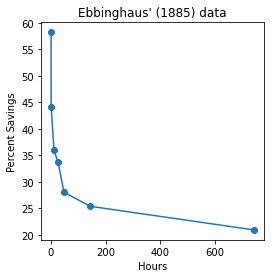

In [3]:
data = [[0.13486782952710996, 58.192771084337345],
        [0.310196007912225, 44.1566265060241],
        [10.753461607624558, 35.903614457831324],
        [25.84517173170292, 33.67469879518073],
        [47.16327998561408, 28.01204819277109],
        [142.8834741952886, 25.361445783132538],
        [743.2161481747886, 20.90361445783133]]

x = [pair[0] for pair in data]
y = [pair[1] for pair in data]

fig = plt.figure(figsize=(4,4))
plt.plot(x, y, "o-")
plt.xlabel("Hours")
plt.ylabel("Percent Savings")
plt.title("Ebbinghaus' (1885) data")
plt.savefig("ebbinghaus.png")


But how exactly does time affect memory? One possibility is that the effect of time is exponential. Exponential function have an expression of the form $P(m) = \alpha^{\beta t}$ with time $t$ being the exponent (hence the name). Another possibility is that the effect of time is that of a power function. Power functions would have the form $P(m) = \alpha \times t^{\beta}$, where time $t$ is a the base and the exponent is a fixed parameter $\beta$. 

This question might seem idle, but is not. Exponential and power curves look almost identical to the naked eye, but they have (very) different mathematical properties. And these mathematical properties are important if we want to build a model. For example, an exponential function has a fixed _half-time_, i.e. a fixed interval of time during which the quantity that we measure reduces by half. This is a familiar property of radioactive materials: if a material has a half time of (let's say), one minute, it means that, after minute, 1 Kg of the material will have become 1/2 Kg, and, one minute later, the 1/2 Kg will have turned into 1/4 Kg. The pace of decay is fixed, and the half-time interval is meaningful measure. But power functions do not have these property; they have other interesting properties (for example, they are scale-invariant) but their pace is ever changing. 

The simplest way to determine whether a particular function is an exponential or a power function is to plot them on modified axes. If both the $x$ and $y$ axes are in log-scale (a so-called _log-log plot_), the power function would look like a straight line, but the exponential function would look like a curve\footnote{The exponential would look like a straight line if only the $x$-axis in log-scale.}. For example, we can take the original data from Ebbinghaus and then plot them on a log-log plot. The result, shown in the figure below, is an almost perfect straight line.


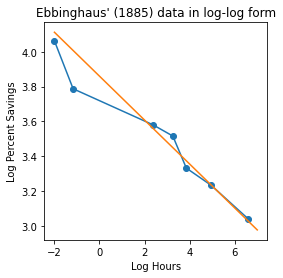

In [4]:
fig = plt.figure(figsize=(4,4))
plt.plot(np.log(x), np.log(y), "o-")
plt.xlabel("Log Hours")
plt.ylabel("Log Percent Savings")
plt.title("Ebbinghaus' (1885) data in log-log form")

xvals = np.linspace(-2, 7)
yvals = 3.86 - 0.126*xvals
plt.plot(xvals, yvals)

plt.savefig("ebbinghaus-log-log.png")

# The ACT-R Theory


The rational analysis framework, together with the power law of forgetting, forms the bases of what is, perhaps, the most influential explanatory model of human memory, ACT-R . Many other important models (e.g., REM: or MINERVA) share almost identical assumptions, so we can focus on ACT-R without losing generality. Note that, although ACT-R has grown to be a much more complete theory that spans more than memory, here we will focus only on its long-term memory component.

Initially, we will not make any assumption about how memories are internally represented. Instead, we will assume that our brain registers large amounts of information into "snapshots" and that these snapshots, which we will refer to as a {\em memories}, can be accessed later on.

Each time a snapshot is taken, a new _trace_ is made. Each trace decays with time. So, if we indicate as $t_i$ the time at which the the $i$-th trace was created, then we indicate that the odds of retrieving it decay with a power function:

\begin{equation}
    \label{eq:actr:odds_trace}
    \frac{P(i)}{P( \neg i)} = (t - t_i)^{-d}
\end{equation}


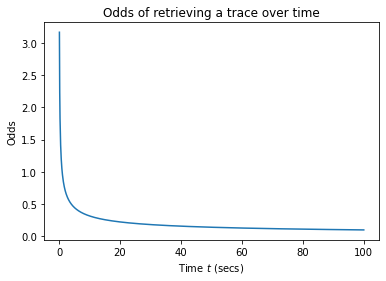

In [2]:
t = np.linspace(0.1, 100, 1000)
d = 0.5
odds = t**-d
plt.plot(t, odds)
plt.xlabel(r"Time $t$ (secs)")
plt.ylabel("Odds")
plt.title("Odds of retrieving a trace over time")
plt.savefig("trace_odds.png")

where $d$ is the {\em decay rate} of memory, i.e., the speed at which memories are forgotten. Figure \ref{fig:actr:trace_odds} illustrates the retention curve of a trace created at time $t_i = 0$ with a decay rate of $d = 0.5$.

In the ACT-R model, it is assumed that the contribution of all traces is a summed, that is, each trace contributes linearly to the odds of retrieving the memory it belongs to. Thus, the odds of retrieving a memory $m$ is the sum of the odds of retrieving any of its associated traces. 
\begin{eqnarray}
    \label{eq:actr:odds_memory}
    \frac{P(m)}{P( \neg m)} &=& \sum_i \frac{P(i)}{P(\neg i)} \nonumber \\
                            &=& \sum_i (t - t_i)^{-d} \nonumber 
\end{eqnarray}

Finally, it is common to express memory in terms of {\em activation}, a quantity that is defined as the {\em log odds} of retrieving a memory. Formally, the activation $A(m)$ of a memory $m$ is given by Equation \ref{eq:actr:activation_odds}.

\begin{equation}
    A(m) = \log \frac{P(m)}{P(\neg m)}
    \label{eq:actr:activation_odds}
\end{equation}
    
One might wonder why it would be necessary to add yet another measure of memory, after probabilities and odds. The main reason is that activation is a {\em convenient} measure. Unlike probabilities or odds, activation values span the entire domain of real numbers, from $-\infty$ to $+\infty$. The mid-point at which a memory is equally likely to be retrieved or forgotten, which corresponds to a probability value of $P(m) = 0.5$ and an odds value of $P(m) / P(\neg m) = 1$, becomes an activation value of $A(m) = 0$. In this sense, activation values can be thought of as forming a scale with a meaningful zero value. A memory with a positive activation value is more likely than not to be remembered, and a memory with a negative activation value is more likely than not to be forgotten. For this reason, it is convenient to refer to the value of $A(m) = 0$ as to the +_orgetting threshold_.
    
The relationship between the odds of retrieving individual traces, the activation of a memory, and the forgetting threshold  is shown in the Figure below 

/tmp/ipykernel_20662/2203704872.py:7: RuntimeWarning: invalid value encountered in power
  odds2 = (t-t2)**-d
/tmp/ipykernel_20662/2203704872.py:8: RuntimeWarning: invalid value encountered in power
  odds3 = (t-t3)**-d


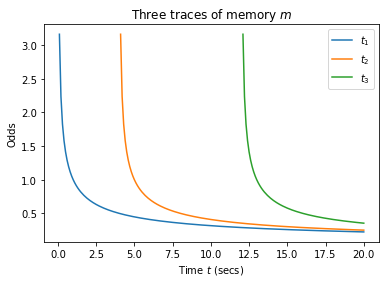

In [5]:
t = np.linspace(0.1, 20, 200)
t1 = 0
t2 = 4
t3 = 12
d = 0.5
odds1 = (t-t1)**-d
odds2 = (t-t2)**-d
odds3 = (t-t3)**-d
plt.plot(t, odds1)
plt.plot(t, odds2)
plt.plot(t, odds3)
plt.xlabel("Time $t$ (secs)")
plt.ylabel("Odds")
plt.title("Three traces of memory $m$")
plt.legend(labels=["$t_1$", "$t_2$", "$t_3$"])
plt.savefig("traces_memory.png")

The activation of memory $m$ is the log of the sum of the odds of each trace

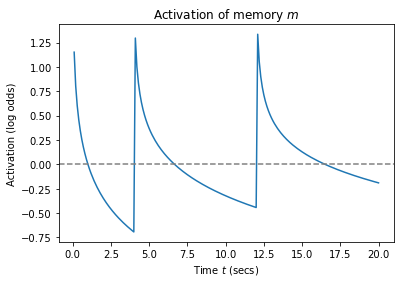

In [32]:
np.nan_to_num(odds2, nan=0, copy=False)
np.nan_to_num(odds3, nan=0, copy=False)
activation = np.log(odds1 + odds2 + odds3)
plt.plot(t, activation)
plt.xlabel("Time $t$ (secs)")
plt.ylabel("Activation (log odds)")
plt.title("Activation of memory $m$")
plt.axhline(0, color="grey", linestyle="--")
plt.savefig("activation_memory.png")

And these are the same two figures lined up on the same plot:

/tmp/ipykernel_20662/2522430058.py:4: RuntimeWarning: invalid value encountered in power
  odds2 = (t-t2)**-d
/tmp/ipykernel_20662/2522430058.py:5: RuntimeWarning: invalid value encountered in power
  odds3 = (t-t3)**-d


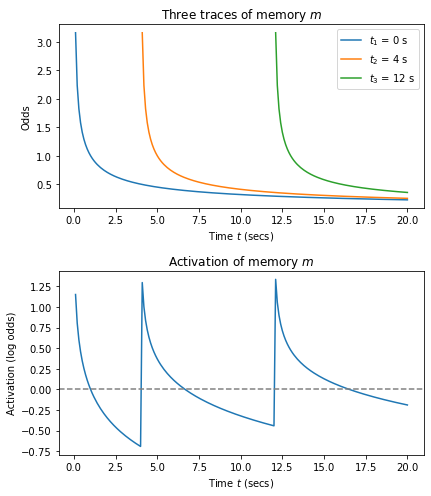

In [6]:
fig, axs = plt.subplots(2,1, figsize=(6,7))

odds1 = (t-t1)**-d
odds2 = (t-t2)**-d
odds3 = (t-t3)**-d

axs[0].plot(t, odds1)
axs[0].plot(t, odds2)
axs[0].plot(t, odds3)
axs[0].set_xlabel("Time $t$ (secs)")
axs[0].set_ylabel("Odds")
axs[0].set_title("Three traces of memory $m$")
axs[0].legend(labels=["$t_1$ = %d s" % t1, "$t_2$ = %d s" % t2, "$t_3$ = %d s" % t3])

np.nan_to_num(odds2, nan=0, copy=False)
np.nan_to_num(odds3, nan=0, copy=False)
activation = np.log(odds1 + odds2 + odds3)
axs[1].plot(t, activation)
axs[1].set_xlabel("Time $t$ (secs)")
axs[1].set_ylabel("Activation (log odds)")
axs[1].set_title("Activation of memory $m$")
axs[1].axhline(0, color="grey", linestyle="--")
plt.tight_layout()
plt.savefig("activation_traces_memory.png")

## Basic Effects of Declarative Memory: Frequency and Recency 


Any good memory model should be able to correctly explain the fundamental effects reported in the literature. In addition to the power law of forgetting \cite{newell1981mechanisms}, other important memory effects include the recency, frequency, and spacing effect. 

The activation equation of _A(m)_  captures the basic effects of recency and frequency. Recency arises as a consequence of the power law of forgetting, which makes the activation of a memory decline as a power function of its age. Frequency, on the other hand, depends on the summed effect of the accumulation of traces, by which a makes a memory with more associated traces retains greater activation than a memory with the same age but fewer associated traces.

Here is the effect of recency:

## Spacing effect

This simple model has no spacing effect

/tmp/ipykernel_11954/368435948.py:7: RuntimeWarning: invalid value encountered in power
  odds21 = (t-t21)**-d
/tmp/ipykernel_11954/368435948.py:8: RuntimeWarning: invalid value encountered in power
  odds22 = (t-t22)**-d


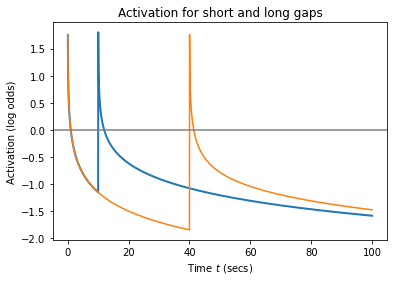

In [88]:
t1 = 0
t21 = 10
t22 = 40
t = np.linspace(0.03, 100, 3000)

odds1 = (t-t1)**-d
odds21 = (t-t21)**-d
odds22 = (t-t22)**-d


np.nan_to_num(odds21, nan=0, copy=False)
np.nan_to_num(odds22, nan=0, copy=False)
activation1 = np.log(odds1 + odds21)
activation2 = np.log(odds1 + odds22)
plt.plot(t, activation1, linestyle="-", linewidth=2)
plt.plot(t, activation2, linestyle="-")
plt.xlabel("Time $t$ (secs)")
plt.ylabel("Activation (log odds)")
plt.title("Activation for short and long gaps")
plt.axhline(0, color="grey", linestyle="-")
plt.savefig("spacing.png")

## Modified spacing

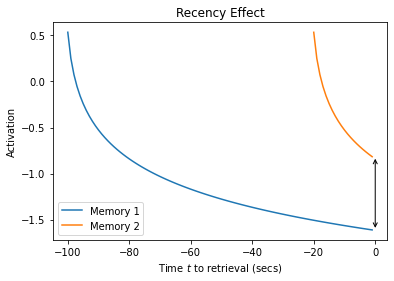

In [61]:
memory = pau.Memory()
fact = {"instructor" : "Andrea Stocco"}
memory.learn(**fact)
curve1 = []
for i in range(100):
    if i % 100 == 0:
        memory.retrieve(**fact)
        memory.learn(advance = 1, **fact)
    else:
        memory.advance(1)
    curve1.append(memory.retrieve(**fact)._base_activation)


memory = pau.Memory()
curve2 = []
for i in range(101):
    if i < 80:
        curve2.append(None)
        memory.advance(1)
    elif i == 80:
        memory.learn(**fact)
        memory.learn(advance = 0.001, **fact)
    else:
        memory.advance(1)
        curve2.append(memory.retrieve(**fact)._base_activation)

time = range(-100,0)
plt.plot(time, curve1)
plt.plot(time, curve2)
plt.annotate("", xy=(0, curve1[-1]), xytext=(0, curve2[-1]),
            arrowprops=dict(arrowstyle="<->"))
plt.legend(["Memory 1", "Memory 2"])
plt.title("Recency Effect")
plt.xlabel("Time $t$ to retrieval (secs)")
plt.ylabel("Activation")
plt.savefig("figures/recency.png")
plt.show()

Text(0, 0.5, 'Probability of retrieval')

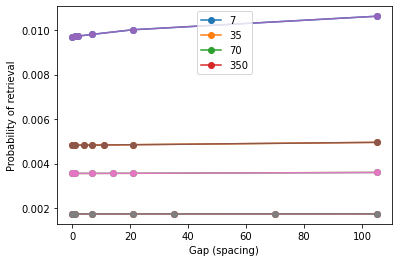

In [3]:
from math import log
from math import exp


# Cepeda's experiment design
design = {7 : [0.002, 1, 2, 7, 21, 105],
         35 : [0.002, 1, 4, 7, 11, 21, 105],
         70 : [0.002, 1, 7, 14, 21, 105],
         350 : [0.002, 1, 7, 21, 35, 70, 105]}


# Convert days into seconds
daysec = 60*60*24
d = .5

results = {}

for ri in design.keys():
    ri_results = []
    gaps = design[ri]
    for gap in gaps:
        risec = ri * daysec
        gapsec = gap * daysec
        t = (ri + gap)*daysec
        t1 = 0
        t2 = gapsec
        odds1 = (t - t1)**-d
        prob1 = odds1 / (odds1 + 1)
        
        weight = 1
        #weight = (1 - prob1) # Prob
        weight = -log(prob1) # Surprisal
        
        d2 = d
        d2 = odds1 + d
        
        odds2 = (t - t2)**-d2 
        w_odds2 = weight * odds2 
        #print([odds1, prob1, odds2, w_odds2])
        odds = odds1 + w_odds2
        prob = odds / (odds + 1)
        ri_results.append(odds)
    results[ri] = ri_results
        

for ri in design.keys():
    x = design[ri]
    y = results[ri]
    plt.plot(x, y, "o-")
plt.legend(labels=design.keys())
plt.xlabel("Gap (spacing)")
plt.ylabel("Probability of retrieval")


for ri in design.keys():
    x = design[ri]
    y = results[ri]
    plt.plot(x, y, "o-")
plt.legend(labels=design.keys())
plt.xlabel("Gap (spacing)")
plt.ylabel("Probability of retrieval")


and the effect of frequency:

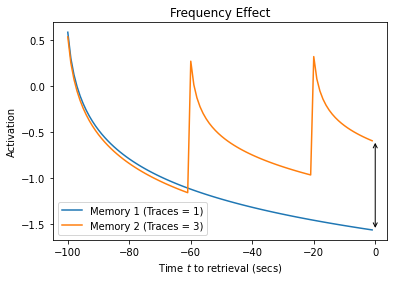

In [62]:
## Frequency

memory = pau.Memory()
memory.learn(**fact)
curve1 = []
for i in range(100):
    if i % 40 == 0:
        memory.retrieve(**fact)
        memory.learn(advance = 1, **fact)
    else:
        memory.advance(1)
    curve1.append(memory.retrieve(**fact)._base_activation)


memory = pau.Memory()
memory.learn(**fact)
curve2 = []
for i in range(100):
    if i % 40 ==0 and i < 40:
        memory.retrieve(**fact)
        memory.learn(advance = 1, **fact)
    else:
        memory.advance(1)
    curve2.append(0.05 + memory.retrieve(**fact)._base_activation)

plt.plot(time, curve2)
plt.plot(time, curve1)


plt.annotate("", xy=(0, curve1[-1]), xytext=(0, curve2[-1]),
            arrowprops=dict(arrowstyle="<->"))

plt.legend(["Memory 1 (Traces = 1)", "Memory 2 (Traces = 3)"])
plt.title("Frequency Effect")

plt.xlabel("Time $t$ to retrieval (secs)")
plt.ylabel("Activation")
plt.savefig("figures/frequency.png")
plt.show()
#plt.grid()

# Decision Making with Declarative Memory

To test this, we will use Frank's PSS task.

In [ ]:
class PSS_Object():
    """A generic object for PSS task components"""
    ACTIONS = ("A", "C", "E", "F", "D", "B")
    NEG_ACTIONS = tuple("-" + x for x in ACTIONS)
    REWARD_TABLE = {"A" : 0.8, "C" : 0.7, "E" : 0.6,
                    "F" : 0.4, "D" : 0.3, "B" : 0.2}

    def is_action(self, action):
        """An action is valid only if it belongs to the list of possible actions"""
        return action[-1] in self.ACTIONS
    
    def prob_reward(self, action):
        """Returns the probability of obtaining a reward given an action"""
        if self.is_action(action):
            return self.REWARD_TABLE[action]
        
    def get_reward(self, action):
        """Return a probabilistic reward associated with an action"""
        i = random.random()
        if i <= self.prob_reward(action):
            return 1.0
        else:
            return -1.0
    
    def complement_action(self, action):
        """Returns the complement action (i.e., -A for A, and A for -A)""" 
        if self.is_action(action):
            if action.startswith("-"):
                return action[-1]
            else:
                return "-" + action
        
class PSS_State(PSS_Object):
    """
A state in the PSS object. A state is consists of two possible options
to choose from, one on the left and one on the right.
    """
    def __init__(self, options = ("A", "B")):
        """Initializes a state, with default options being (A, B)"""
        if self.is_options(options):
            self.options = options
        else:
            self.options = None
            
    @property
    def left(self):
        """The option on the left""" 
        if (self.is_options(self.options)):
            return self.options[0]
        else:
            return None
            
    
    @property
    def right(self):
        """The option on the right"""
        if (self.is_options(self.options)):
            return self.options[1]
        else:
            return None
           

    def is_options(self, options):
        """Checks whether a given tuple is a set of options"""
        if len(options) == 2 and not False in [x in self.ACTIONS for x in options]:
            return True
        else:
            return False
    
    def __eq__(self, other):
        """Equality if the options are the same, independent of order"""
        return (self.left == other.left and self.right == other.right) or \
               (self.left == other.right and self.right == other.left)
    
    def __repr__(self):
        """Represented as a tuple '(O1, O2)'"""
        return "(%s,%s)" % (self.left, self.right)
    
    def __str__(self):
        return self.__repr__()
    
    
class PSS_Decision(PSS_Object):
    """A decision made during the PSS task"""
    def __init__(self, state = None, action = None, reward = 0.0):
        self.state = state
        self.action = action
        self.reward = reward
    
    def is_state(self, state):
        """Checks if something is a valid state"""
        return isinstance(state, PSS_State)
    
    @property
    def successful(self):
        """Success if reward > 0."""
        if self.reward > 0:
            return True
        else:
            return False
    
    @property
    def optimal(self):
        """A an action was optimal if it corresponded to the highest prob option"""
        s = self.state
        apos = s.options.index(self.action)
        probs = [self.prob_reward(x) for x in s.options]
        ppos = probs.index(max(probs))
        return apos == ppos
    
    def includes_option(self, option):
        """Checks if the decision included option 'option'"""
        return option in self.state.options
    
    
    def __repr__(self):
        """The decision as a string"""
        return "<%s, %s, %0.1f>" % (self.state, self.action, self.reward)



class PSS_Task(PSS_Object):
    """An object implementing the PSS task"""
    CRITERION = {"AB" : 0.65, "CD" : 0.60, "EF" : 0.50}
    
    TRAINING_BLOCK = ((("A", "B"),) * 10 +
                      (("B", "A"),) * 10 +
                      (("C", "D"),) * 10 +
                      (("D", "C"),) * 10 +
                      (("E", "F"),) * 10 +
                      (("F", "E"),) * 10)
    
    TEST_BLOCK = ((("A", "B"),) * 2 + (("B", "A"),) * 2 +
                  (("A", "C"),) * 2 + (("C", "A"),) * 2 +
                  (("A", "D"),) * 2 + (("D", "A"),) * 2 +
                  (("A", "E"),) * 2 + (("E", "A"),) * 2 +
                  (("A", "F"),) * 2 + (("F", "A"),) * 2 +

                  (("B", "C"),) * 2 + (("C", "B"),) * 2 +
                  (("B", "D"),) * 2 + (("D", "B"),) * 2 +
                  (("B", "E"),) * 2 + (("E", "B"),) * 2 +
                  (("B", "F"),) * 2 + (("F", "B"),) * 2 +
                  
                  (("C", "D"),) * 2 + (("D", "C"),) * 2 +
                  (("C", "E"),) * 2 + (("E", "C"),) * 2 +
                  (("C", "F"),) * 2 + (("F", "C"),) * 2 +
                  
                  (("D", "E"),) * 2 + (("E", "D"),) * 2 +
                  (("D", "F"),) * 2 + (("F", "D"),) * 2 +
    
                  (("E", "F"),) * 2 + (("F", "E"),) * 2)

                  
    
    PHASES = ("Training", "Test")
    
    def __init__(self):
        """Initializes a PSS task experiment"""
        self.index = 0
        self.phase = "Training"
        
        self.train = self.instantiate_block(self.TRAINING_BLOCK)        
        self.test =  self.instantiate_block(self.TEST_BLOCK)
        self.blocks = dict(zip(self.PHASES, [self.train, self.test]))                
        self.history = dict(zip(self.PHASES, [[], []]))
        
        self.state = self.next_state()
    
    def instantiate_block(self, block):
        """Instantiates and randomizes a block of trials"""
        trials = [PSS_State(x) for x in block]
        random.shuffle(trials)
        return deque(trials)
    
    def criterion_reached(self):
        """Reached criterion for successful learning"""
        training = self.history['Training']
        if len(training) < 60:
            return False
        
        else:
            if len(training) > 60:
                training = training[-60:]
            ab = self.calculate_accuracy(training, "A")
            cd = self.calculate_accuracy(training, "C")
            ef = self.calculate_accuracy(training, "E")
            
            if ab >= self.CRITERION["AB"] and cd >= self.CRITERION["CD"] and ef >= self.CRITERION["EF"]:
                return True
            else:
                return False
    
    def next_state(self):
        """Next state (transitions are independent of actions)"""
        state_next = None
        current_block = self.blocks[self.phase]
        if len(current_block) == 0:
            if self.phase == "Training":
                if self.criterion_reached() or len(self.history["Training"]) >= 360:
                    # Move to the Test phase and recalculate the current block.
                    self.phase = "Test"
                      
                else:
                    self.blocks["Training"] = self.instantiate_block(self.TRAINING_BLOCK)
                    
                current_block = self.blocks[self.phase]
                state_next = current_block.popleft()
            
            else: 
                state_next = None # End of the experiment
        else:
            state_next = current_block.popleft()
        return state_next
                    
    
    def execute_action(self, action):
        """Executes and action and returns the new state and a reward"""
        if self.is_action(action):
            if action.startswith("-"):
                # This handles the cases where an agent chooses NOT
                # to pick a specific action (as in the BG models)
                action = [x for x in self.state.options if x is not action[-1]][0]
            
            r = None
            if self.phase == "Training":
                r = self.get_reward(action)
            
            # Update history
            d = PSS_Decision(self.state, action, reward = r)
            self.history[self.phase].append(d)
            
            self.state = self.next_state()
            return (self.state, r)
    
    def calculate_accuracy(self, decisions, option, exclude = "None"):
        """Calculates accuracy across all decisions that include option 'option' but not option 'exclude'"""
        opt = [x.optimal for x in decisions if x.includes_option(option) and not x.includes_option(exclude)]
        return np.mean(opt)
        
    def accuracies(self):
        """Returns the Choose / Avoid accuracies"""
        test = self.history["Test"]
        if len(test) >= 60:
            return (self.calculate_accuracy(test, option = 'A', exclude = 'B'),
                    self.calculate_accuracy(test, option = 'B', exclude = 'A'))
            

Now we need to define a few functions to choose.

In [ ]:
class DMAgent():
    """A declarative memory agent"""
    def __init__(self, nsamples=3):
        """Initializes an agent"""
        self.memory = pau.Memory()
        self.nsamples = nsamples
        self.init_memory()
        
    def init_memory(self):
        """Initializes the agent with some fake memories (to make the first choice possible)"""
        dm = self.memory
        dm.learn(action="A", reward=-1)
        dm.learn(action="B", reward=-1)
        dm.learn(action="C", reward=-1)
        dm.learn(action="D", reward=-1)
        dm.learn(action="E", reward=-1)
        dm.learn(action="F", reward=-1)
    
    def evaluate(self, option):
        """Evaluates an option by sampling from memory"""
        res = []
        dm = self.memory
        for i in range(self.nsamples):
            instance = dm.retrieve(action = option)
            res.append(instance["reward"])
        return np.sum(res)
    
    def choose(self, state):
        """Choose an option"""               
        val1, val2 = [self.evaluate(option) for option in [state.left, state.right]]
        if val1 > val2:
            return state.left
        elif val1 < val2:
            return state.right
        else:
            return random.choice([state.left, state.right])
                       
def PSS_loop(agent, task):
    while task.state is not None:
        state1 = task.state
        choice = agent.choose(state1)
        state2, reward1 = task.execute_action(choice)
        if reward1 is not None:
            agent.memory.learn(action = choice, reward = reward1)
        agent.memory.advance(1)
    
def plot_results(results, param_values):
    x = [1,2]   # X axis
    jet = cm = plt.get_cmap('jet') 
    cNorm  = colors.Normalize(vmin = 0, vmax = (len(param_values) - 1))
    scalarMap = cmx.ScalarMappable(norm = cNorm, cmap = jet)

    fig, ax = plt.subplots()

    for i in range(len(param_values)):
        p = param_values[i]
        colorVal = scalarMap.to_rgba(i)
        ax.plot(x, results[p], "o-", color=colorVal)
    
    ax.axis([0.75, 2.25, 0.48, 0.95])
    ax.set_ylabel("Mean Accuracy")
    ax.set_xticks([1,2])
    ax.set_xticklabels(["Choose", "Avoid"])
    #fig.colorbar(ax, param_values)
    plt.legend(["N = %.2f" % x for x in param_values], loc="best", ncol=2)

Let's do a simple test:

In [ ]:
agent = DMAgent()
task = PSS_Task()
PSS_loop(agent, task)
task.accuracies()

And let's inspect the model's memories:

In [ ]:
A = []
fig, ax = plt.subplots(1, 1)
labels=[]
for action in "ABCDEF":
    for reward in (1, -1):
        labels.append("[%s, %d]" % (action, reward))
        chunk = agent.memory.retrieve(action = action, reward = reward)
        if chunk is not None:
            A.append(chunk._base_activation)
        else:
            A.append(0)
ax.bar(range(len(labels)), height=A, color=["orange", "dodgerblue"]*6)
ax.set_title("Activation of Different Memories")
ax.set_ylabel("Activation")
ax.set_xlabel("Memories in DM")
ax.set_ylim(-3.5, 2)
       
for i in range(len(labels)):
    ax.text(i, A[i] + 0.1, labels[i], ha="center", va="bottom", rotation="vertical")
plt.grid()
plt.savefig("figures/pss_memory_activation.png")

In [ ]:
results = {}
for n in range(1, 11):
    performance = []
    for i in range( 250 ):
        task = PSS_Task()
        agent = DMAgent(nsamples = n)
        PSS_loop(agent, task)
        performance.append(task.accuracies())

    results[n] = (np.mean([x[0] for x in performance]), np.mean([x[1] for x in performance]))

plot_results(results, list(range(1, 11)))
plt.savefig("figures/decision_by_sampling.png")
plt.show()

## Instance-based Learning

We can now generalize this approach to complex tasks using the Instance-Based Learning (IBL) framework. In IBL, _instances_ are memorized as episodic memories of the form [_state_, _decision_, _utility_] (_SDU_).

We will apply this framework to the RL problem of navigating a maze.

In [ ]:
class Maze():
    """A maze environment"""

    ACTIONS = ("up", "down", "left", "right") # List of actions
    INITIAL_STATE = (0, 0) # Always starts at the topleft corner
    
    def __init__(self, fname = "data/grid.txt"):
        """Inits a maze by loading the grid file"""
        self.grid = np.loadtxt(fname)
        self.state = self.INITIAL_STATE
        self.end = False


    def state_transition(self, state1, action1):
        "Defines the next state gien the "
        x, y = state1
        
        # If we have reached the cheese, we transition 
        # to the terminal state
        if self.grid[x, y] > 0:
            return None
        
        # Otherwise, we update the position
        state2 = copy(state1)
        
        if action1 in self.ACTIONS:
            if action1 == "up":
                if x > 0:
                    state2 = (x - 1, y)
            
            elif action1 == "left":
                if y > 0:
                    state2 = (x, y - 1)
            
            elif action1 == "down":
                if x < (self.grid.shape[0] - 1):
                    state2 = (x + 1, y)

            elif action1 == "right":
                if y < (self.grid.shape[1] - 1):
                    state2 = (x, y + 1)
                    
        return state2
                    
    
    def reward_transition(self, state1, action1, state2):
        """Reward is -1 for bouncing against the walls, and whatever is on the grid otherwise"""
        #if state1 == state2:
        #    return -1
        if state2 == None:
            return 0
        else:
            return self.grid[state2[0], state2[1]]
        
    
    # Quick way to combine State transitions and Reward transitions 
    def transition(self, action1):
        """Changes the state following an action"""
        state1 = self.state
        state2 = self.state_transition(state1, action1)
        reward2 = self.reward_transition(state1, action1, state2)
        
        self.state = state2
        return (state2, reward2) # Returns s_t+1, r_t+1

And here is the code for our IBL-based agent

In [ ]:
class IBLAgent():
    """A instance-based learning agent"""
    def __init__(self):
        """Initializes an agent"""
        self.actions = ("up", "left", "down", "right")
        self.memory = pau.Memory()
        self.init_memory()
        
    def init_memory(self):
        """Initializes the agent with some preliminary SDUs (to make the first choice possible)"""
        dm = self.memory
        for i in range(4):
            for j in range(4):
                state = "<%d-%d>" % (i, j)
                for action in self.actions:
                    dm.learn(state = state, decision = action, utility = -1)
                
    
    def evaluate(self, state, option):
        """Evaluates an option by sampling from memory"""
        res = []
        dm = self.memory
        return dm.blend("utility", state = state, decision = option)
    
    def choose(self, state):
        """Choose an option"""        
        actions = list(self.actions)
        random.shuffle(actions)
        vals = [self.evaluate(state, x) for x in actions]
        min_val = np.min(vals)
        V = dict(zip(actions, vals))
        best_actions = [x for x in actions if V[x] == min_val]
        return random.choice(best_actions)
    
def maze_run(agent, maze):
    while maze.state is not None:
        state1 = "<%d-%d>" % maze.state
        choice = agent.choose(state1)
        state2, reward1 = maze.transition(choice)
        
        if state2 is not None:
            state2 = "<%d-%d>" % state2
        
            if reward1 <= 0:
                # Use Value of state2
                utility = np.max([agent.memory.blend("utility", state = state2, decision = x) for x in agent.actions])
            else:
                utility = reward1
        
            agent.memory.learn(state = state1, decision = choice, utility = utility)
            agent.memory.advance(1)
        
def run_trials(agent, maze, n):
    for i in range(n):
        maze.state = Maze.INITIAL_STATE
        maze_run(agent, maze)
        
 

Now, we can visualize what the agent has learned about the utlity of performing any given action in a particular position of the maze.  

In [ ]:
maze = Maze()
agent = IBLAgent()
maze_run(agent, maze)
run_trials(agent, maze, 8)

def plot_ibl_tables(agent, **kwargs):
    """Visualizes the Q tables, one per action"""
    fig, axs = plt.subplots(2, 2, figsize=(5,5))
    #i = 0
    for i, a in enumerate(agent.actions):
        # Create the corresponding state table
        data = np.zeros((4,4))
            
        for j in range(4):
            for k in range(4):
                state = "<%d-%d>" % (j, k)
                data[j, k] = agent.memory.blend("utility", state = state, decision = a)  
                
        # Plot the heatmap
        im = axs.flat[i].imshow(data, **kwargs, cmap="viridis")

        # We want to show all ticks...
        axs.flat[i].set_xticks(np.arange(data.shape[1]))
        axs.flat[i].set_yticks(np.arange(data.shape[0]))
        axs.flat[i].set_xticklabels(range(1,5))
        axs.flat[i].set_yticklabels(range(1,5))

        # Let the horizontal axes labeling appear on top.
        axs.flat[i].tick_params(top=False, bottom=True,
                                labeltop=False, labelbottom=True)

        # Turn spines off and create white grid.
        for edge, spine in axs.flat[i].spines.items():
            spine.set_visible(False)

        axs.flat[i].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
        axs.flat[i].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
        axs.flat[i].grid(which="minor", color="grey", linestyle='-', linewidth=2)
        axs.flat[i].tick_params(which="minor", bottom=False, left=False)
        axs.flat[i].set_title(r"$BV$s for '%s'" % (a,))

        #i += 1
    
    for ax in axs.flat:
        ax.label_outer()

    fig.subplots_adjust(right=0.85, hspace=0.2)
    cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    #fig.tight_layout()

plot_ibl_tables(agent)
plt.savefig("figures/blended_values_tables.png")
plt.show()

Note the generality of IBL. Because of blending, it is absolutely possible to obtain blended values for _states_ as well as _actions_. In fact, it is possible to naturally represent states and actions in continuous form

In [ ]:
def plot_ibl_state(agent, **kwargs):
    """Visualizes the V table"""
    fig, axs = plt.subplots(1, 1, figsize=(3,3))
    data = np.zeros((4,4))
            
    for j in range(4):
        for k in range(4):
            state = "<%d-%d>" % (j, k)
            data[j, k] = agent.memory.blend("utility", state = state)  
                
    # Plot the heatmap
    im = axs.imshow(data, **kwargs, cmap="viridis")

    # We want to show all ticks...
    axs.set_xticks(np.arange(data.shape[1]))
    axs.set_yticks(np.arange(data.shape[0]))
    axs.set_xticklabels(range(1,5))
    axs.set_yticklabels(range(1,5))

    # Let the horizontal axes labeling appear on top.
    axs.tick_params(top=False, bottom=True,
                                labeltop=False, labelbottom=True)

    # Turn spines off and create white grid.
    for edge, spine in axs.spines.items():
        spine.set_visible(False)

    axs.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    axs.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    axs.grid(which="minor", color="grey", linestyle='-', linewidth=2)
    axs.tick_params(which="minor", bottom=False, left=False)
    axs.set_title(r"$BV$s for states")

plot_ibl_state(agent)
plt.savefig("figures/blended_values_states.png")
plt.show()

# Distinguishing IBL and RL 

IBL and RL make almost overlapping predictions. One clever way to distinguish them in behavioral data was shown by Ann Collins in 2018.

In [ ]:
stimuli = ("car", "house", "knife", "cup", "fork", "screwdriver")
responses = ("a", "b", "c")

class CollinsTask():
    def __init__(self, nstimuli = 3, num = 12):
        self.numrep = num
        self.init_stimuli(nstimuli)
        self.numtrials = num * self.nstimuli
        self.history = []
        
    def init_stimuli(self, nstimuli):
        """Fix the stimuli"""
        self.stimuli = stimuli[:nstimuli]
        self.nstimuli = nstimuli
        assoc = {}
        for stimulus in self.stimuli:
            assoc[stimulus] = random.choice(responses)
        self.associations = assoc
        
        trials = list(self.stimuli) * self.numrep
        random.shuffle(trials)
        self.trials = trials
        
        self.current = 0
        self.state = self.trials[self.current]
    
    def transition(self, action):
        """A s1, a1 -> s2, r1 transition"""
        stim = self.state 
        reward = 0
        if action == self.associations[stim]:
            reward = +1
        
        self.current += 1
        if self.current < len(self.trials):
            self.state = self.trials[self.current]
        else:
            self.state = None
        state2 = self.state
        self.history.append((stim, reward))
        return (state2, reward)
        
    def curve(self):
        lists =[]
        for s in self.stimuli:
            performance = [x[1] for x in self.history if x[0] == s]
            lists.append(performance)
        array = np.array(lists)
        return np.mean(array, axis=0)
    
        
class RLModel():
    def __init__(self, epsilon = 0.1, alpha = 0.1):
        self.Q = {}    ## Initial dictionary of (s, a) pairs. At the beginning, it's emtpy.
        self.epsilon = epsilon     # Epsilon for e-greey policy
        self.alpha = alpha         # Learning rate
        self.actions = responses     # Set of possible actions (provide those of Maze.ACTIONS)
        
    def choose(self, state):
        """Selects an action with a epsilon-greedy policy"""
        if random.random() < self.epsilon:
            action = random.choice(self.actions)
        else:
            q = [self.Q[(state, a)] if (state, a) in self.Q.keys() else 0.0 for a in self.actions]
            maxQ = max(q)
            count = q.count(maxQ)
            if count > 1:
                best = [i for i in range(len(self.actions)) if q[i] == maxQ]
                i = random.choice(best)
            else:
                i = q.index(maxQ)

            action = self.actions[i]
        return action
    
    def learn(self, state, action, reward):
        a = self.alpha
        
        qval = 0.0
        
        if (state, action) in self.Q.keys():
            q1 = self.Q[(state, action)]
        
        
        rpe = reward - qval
        qval += a * rpe
        self.Q[(state, action)] = qval
        
    
class IBLModel():
    def __init__(self):
        self.memory = pau.Memory(threshold=0.0)
        self.actions = responses
        
    def choose(self, state):
        res = [self.memory.retrieve(situation = state, action = x, utility = +1) for x in self.actions]
        res = [0 if x is None else 1 for x in res]
        count = res.count(1)
        
        if count > 1:
            best = [i for i in range(len(res)) if res[i] == 1]
            i = random.choice(best)
            
        elif count == 1:
            i = res.index(1)
        
        else:
            i = random.choice(range(len(self.actions)))
        
        return self.actions[i]
    
    def learn(self, state, action, reward):
        state = "%s" % (state,)
        self.memory.learn(advance = 0.5, situation = state, action = action, utility = reward)
        

def collins_loop(agent, task):
    while task.state is not None:
        state1 = task.state
        action1 = agent.choose(state1)
        state2, reward1 = task.transition(action1)
        agent.learn(state1, action1, reward1)
        
def run_sims(atype, nstimuli, n):
    partials = np.zeros((n, 12))
    
    for i in range(n):
        if atype == "IBL":
            agent = IBLModel()
        else:
            agent = RLModel()
        task = CollinsTask(nstimuli = nstimuli)
        collins_loop(agent, task)
        partials[i,] = task.curve()
        
    return np.mean(partials, axis=0)
    

Let's see how both models perform the Collins task

In [ ]:
NSIMS = 500

rl3 = run_sims("RL", 3, NSIMS)
rl6 = run_sims("RL", 6, NSIMS)
ibl3 = run_sims("IBL", 3, NSIMS)
ibl6 = run_sims("IBL", 6, NSIMS)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(rl3, "-o", label = "$N$ = 3")
axs[0].plot(rl6, "-o", label = "$N$ = 6")
axs[0].set_title("RL Agent")
#axs[0].legend()

axs[1].plot(ibl3, "-o", label = "$N$ = 3")
axs[1].plot(ibl6, "-o", label = "$N$ = 6")
axs[1].set_title("IBL Agent")
#axs[0].legend()

for ax in axs:
    ax.legend()
    
    xticks = list(range(12))
    ax.set_xticks(xticks)
    ax.set_xticklabels([1 + i for i in xticks])
    ax.set_xlabel("Stimulus Presentation")
    
    ax.set_ylabel("Proportion Correct")
    
                   
fig.suptitle("Performance of RL and IBL agents in the Collins task") 
fig.tight_layout()
plt.savefig("figures/rl_vs_ibl.png")
plt.show()